### MNIST Digits Classification AI Model ###

In [37]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [38]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

train_data = datasets.MNIST(
    root='data', 
    train=True, 
    download=True, 
    transform=transform
)

test_data = datasets.MNIST(
    root='data', 
    train=False, 
    download=True, 
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Classifier(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying MNIST digits.

    Architecture:
    - 2 convolutional layers
    - 2 fully connected layers
    - Dropout for regularization
    """

    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 input channel (grayscale), 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 image after pooling
        self.fc2 = nn.Linear(128, 10)  # 10 output classes (digits 0-9)
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 10).
        """
        # Convolution + ReLU + MaxPool
        x = F.relu(self.conv1(x))  # Output shape: (32, 28, 28)
        x = F.max_pool2d(x, 2)      # Output shape: (32, 14, 14)
        
        x = F.relu(self.conv2(x))  # Output shape: (64, 14, 14)
        x = F.max_pool2d(x, 2)      # Output shape: (64, 7, 7)
        
        # Flatten for fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize the model
model = MNIST_Classifier()

In [40]:
# Loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam is a good default)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 10

In [41]:
def train():
    for epoch in range(epochs):
        model.train()  # Set to training mode
        running_loss = 0.0
        
        for images, labels in train_loader:
            # Move data to GPU (if available)
            images, labels = images.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print training loss per epoch
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

In [42]:
# Initialize the model
model = MNIST_Classifier()

# Load the saved weights
model.load_state_dict(torch.load('mnist_digit_model.pth'))

# Set the model to evaluation mode
model.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_4248\1726391030.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mnist_digit_model.pth'))


MNIST_Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [43]:
# train()

model.eval()  # Set to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# torch.save(model.state_dict(), 'mnist_digit_model.pth')

Test Accuracy: 99.11%


In [44]:
from PIL import Image
import torchvision.transforms as transforms

# Load the JPG image
image_path = 'images/testing_image.jpg'  # Replace with your image path
image = Image.open(image_path)

# Define the same transform used during training
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.Grayscale(),       # Convert to grayscale
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Preprocess the image
image = transform(image).unsqueeze(0)  # Add batch dimension
image = image.to(device)  # Move to GPU if available

In [45]:
# Set model to evaluation mode
model.eval()

# Predict
with torch.no_grad():
    output = model(image)
    prediction = torch.argmax(output).item()

print(f"Predicted digit: {prediction}")

Predicted digit: 2


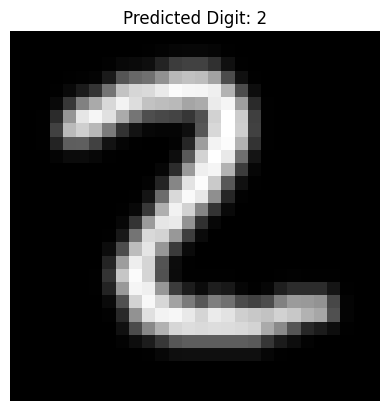

In [46]:
import matplotlib.pyplot as plt

# Convert tensor back to numpy for visualization
image_np = image.squeeze().cpu().numpy()

# Plot the image
plt.imshow(image_np, cmap='gray')
plt.title(f"Predicted Digit: {prediction}")
plt.axis('off')
plt.show()